# Meta Learning

In this notebook, we will implement various algorithms from the paper [A Closer Look at Few-Shot Classification](https://openreview.net/pdf?id=HkxLXnAcFQ).

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").

Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/meta/learning/2019/04/29/Fun-of-Dissecting-Paper/). 

#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Meta%20Learning/meta_learning_maml.ipynb)

## Data

In [0]:
import os
import time
from pathlib import Path
import shutil
from os.path import join
from PIL import Image
import distutils.core

os.mkdir('dataset/')
path = Path('dataset/')

In [0]:
! wget -O images_background.zip https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip?raw=true

In [0]:
! wget -O images_evaluation.zip https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip?raw=true

In [0]:
! unzip -q -n images_background.zip -d {path}
! unzip -q -n images_evaluation.zip -d {path}

In [ ]:
! wget https://raw.githubusercontent.com/jakesnell/prototypical-networks/master/data/omniglot/splits/vinyals/train.txt 
! wget https://raw.githubusercontent.com/jakesnell/prototypical-networks/master/data/omniglot/splits/vinyals/val.txt
! wget https://raw.githubusercontent.com/jakesnell/prototypical-networks/master/data/omniglot/splits/vinyals/test.txt

In [0]:
distutils.dir_util.copy_tree(str(path/'images_evaluation/'), str(path/'images_background'))

In [0]:
print ('Classes:', os.listdir(path/'images_background'))
print ('Total classes:', len(os.listdir(path/'images_background')))

Classes: ['Mongolian', 'Greek', 'Angelic', 'Mkhedruli_(Georgian)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Sylheti', 'Burmese_(Myanmar)', 'Arcadian', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Grantha', 'Gujarati', 'Sanskrit', 'Atlantean', 'Kannada', 'Tifinagh', 'Malay_(Jawi_-_Arabic)', 'Keble', 'Japanese_(katakana)', 'Japanese_(hiragana)', 'Old_Church_Slavonic_(Cyrillic)', 'Alphabet_of_the_Magi', 'Futurama', 'ULOG', 'N_Ko', 'Early_Aramaic', 'Anglo-Saxon_Futhorc', 'Oriya', 'Syriac_(Estrangelo)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Malayalam', 'Armenian', 'Ge_ez', 'Avesta', 'Aurek-Besh', 'Atemayar_Qelisayer', 'Latin', 'Tengwar', 'Asomtavruli_(Georgian)', 'Tibetan', 'Bengali', 'Cyrillic', 'Manipuri', 'Gurmukhi', 'Glagolitic', 'Balinese', 'Tagalog', 'Hebrew', 'Syriac_(Serto)', 'Braille']
Total classes: 50


In [0]:
path = Path(path/'images_background')

In [0]:
def rotate_images():
    dirs = sorted(os.listdir(path))
    for d in dirs:
        char_folder = os.listdir(path/d)
        for character in char_folder:
            for deg in [0, 90, 180, 270]:
                img_files = os.listdir(join(path, d, character))
                rot_folder = "rot%03d"%deg
                rot_folder_path = join(path, d, character, rot_folder)
                if not os.path.exists(rot_folder_path):
                    os.makedirs(rot_folder_path)
                for img in img_files:
                    if 'rot' not in img:
                        rot_img = Image.open(join(path, d, character, img)).rotate(deg)
                        rot_img.save(join(path, d, character, rot_folder, img))

In [0]:
start = time.time()
rotate_images()
print ('Preprocessing Rotation Time taken: %.2f'%(time.time()-start))

In [0]:
os.mkdir('data/')
os.mkdir('data/train')
os.mkdir('data/val')
os.mkdir('data/test')
data_path = Path('data/')

In [0]:
def split_train_val_test(file, q='train'):
    
    with open(file, 'r') as f:
        for line in f:
            shutil.move(str(path/line.split('\n')[0]), join(data_path, q, line.split('\n')[0]))

In [0]:
split_train_val_test('train.txt', 'train')

In [0]:
split_train_val_test('val.txt', 'val')

In [0]:
split_train_val_test('test.txt', 'test')

In [0]:
print ('After splitting number of classes for train, val and test:')
len(os.listdir('data/train/')), len(os.listdir('data/val/')), len(os.listdir('data/test/'))

After splitting number of classes for train, val and test:


(33, 5, 13)

In [0]:
!tar -cvf dataset.tar /content/data

In [ ]:
! pip install pydrive

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# upload = drive.CreateFile({'title': 'dataset.tar'})
# upload.SetContentFile('dataset.tar')
# upload.Upload()

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '19Jinmzv_JNEhOVHg5CZMcgbexzTi4oEC'})
download.GetContentFile('dataset.tar')

In [0]:
! tar -xf dataset.tar

## MAML

We will start with implementing maml algorithm mentioned in the [paper](https://openreview.net/pdf?id=HkxLXnAcFQ).

![maml method](meta_learning/maml_method.png "maml method")
![maml algo](meta_learning/maml_algo.png "maml algo")

![figure](meta_learning/meta_train_test.png "figure")
![maml_classifier](meta_learning/maml.png "classifier")


![implement](meta_learning/implementation.png "implement")

![omniglot](meta_learning/omniglot.png "omniglot")


![result](meta_learning/results_total.png "result")


### Data Preprocessing

In [0]:
import pandas as pd
import os
from os.path import join
import glob
from pathlib import Path
import operator
from functools import reduce
import matplotlib.pyplot as plt
import random
import numpy as np
import imageio
%matplotlib inline

data_path = Path('/content/content/data/')

In [0]:
df_train = pd.DataFrame()
df_val = pd.DataFrame()
df_test = pd.DataFrame()

In [0]:
def read_labels(file, q='train'):
    
    with open(file, 'r') as f:
        lines = f.read().splitlines() 
    return lines

def blow_up_labels(lbl):
    flat_labels = []
    for i, l in enumerate(lbl):
        for _ in range(20):
            flat_labels.append(l)
    return flat_labels

In [0]:
trn_lbl = sorted(read_labels('train.txt', 'train'))
print ('Training Classes:', len(trn_lbl))
df_train['labels'] = blow_up_labels(trn_lbl)

Training Classes: 4112


In [0]:
val_lbl = sorted(read_labels('val.txt', 'val'))
print ('Validation Classes:', len(val_lbl))
df_val['labels'] = blow_up_labels(val_lbl)

Validation Classes: 688


In [0]:
test_lbl = sorted(read_labels('test.txt', 'test'))
print ('Validation Classes:', len(test_lbl))
df_test['labels'] = blow_up_labels(test_lbl)

Validation Classes: 1692


In [0]:
def read_image_paths(q='train'):
    paths = []
    dirs = sorted(os.listdir(data_path/q))
    for d in dirs:
        character_folder = sorted(os.listdir(join(data_path, q, d)))
        for c in character_folder:
            rot_folder = sorted(os.listdir(join(data_path, q, d, c)))
            for r in rot_folder:
                paths.append(sorted(glob.glob(join(data_path, q, d, c, r, '*.png'))))
    return paths

In [0]:
trn_img_list = read_image_paths('train')
flat_img_list = reduce(operator.concat, trn_img_list)
df_train['img_paths'] = flat_img_list

In [0]:
val_img_list = read_image_paths('val')
flat_img_list = reduce(operator.concat, val_img_list)
df_val['img_paths'] = flat_img_list

In [0]:
test_img_list = read_image_paths('test')
flat_img_list = reduce(operator.concat, test_img_list)
df_test['img_paths'] = flat_img_list

In [0]:
trn_lbl_map = dict(zip(trn_lbl, np.array(range(len(trn_lbl)))))
val_lbl_map = dict(zip(val_lbl, np.array(range(len(val_lbl)))))

In [0]:
trn_dict = dict(zip(trn_lbl, trn_img_list))
val_dict = dict(zip(val_lbl, val_img_list))
test_dict = dict(zip(test_lbl, test_img_list))

In [0]:
def show_images(img_path, classes, rows=2, columns=4):
    fig=plt.figure(figsize=(18, 9))
    for i in range(1, columns*rows+1):
        img = imageio.imread(img_path[i-1])    
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label : {classes[i-1]}')
        plt.axis('off')

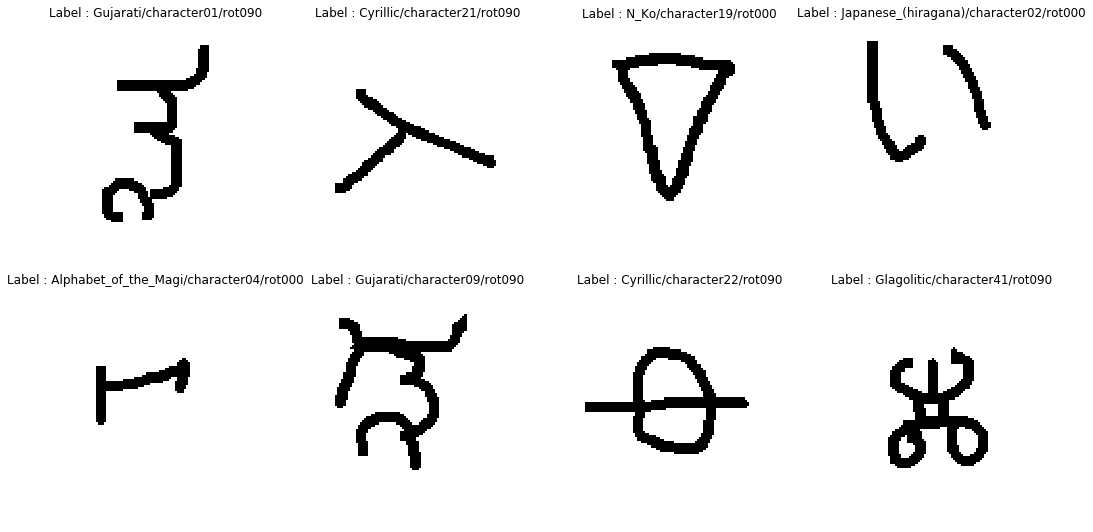

In [0]:
#randomly sample 8 images from train dataset
rnd_num = random.sample(list(np.arange(len(df_train))), 8)
rnd_files = df_train['img_paths'].iloc[rnd_num].values
rnd_lbls = df_train['labels'].iloc[rnd_num].values
show_images(rnd_files, rnd_lbls)

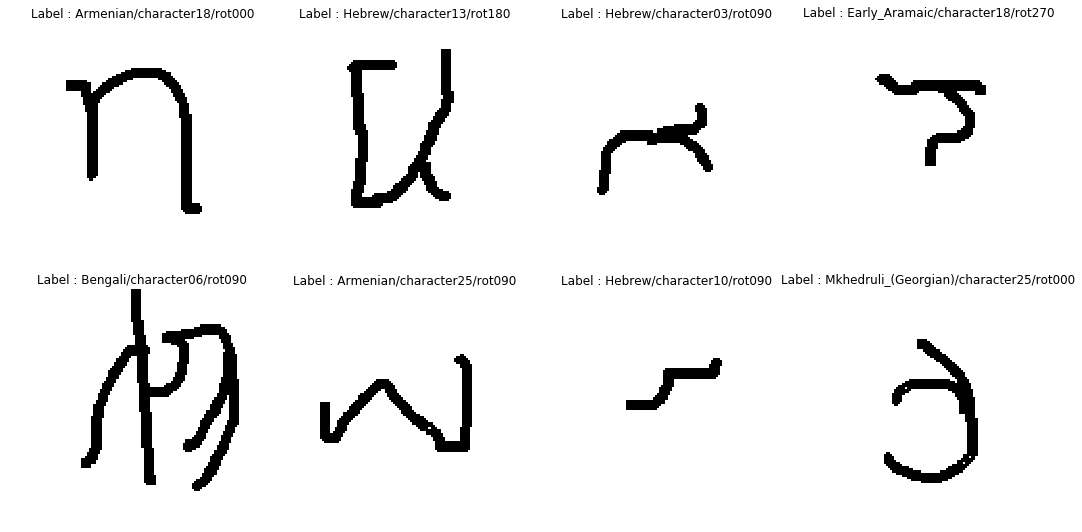

In [0]:
#randomly sample 8 images from val dataset
rnd_num = random.sample(list(np.arange(len(df_val))), 8)
rnd_files = df_val['img_paths'].iloc[rnd_num].values
rnd_lbls = df_val['labels'].iloc[rnd_num].values
show_images(rnd_files, rnd_lbls)

In [0]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import math
import torch.nn.functional as F
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn.utils.weight_norm import WeightNorm
from abc import abstractmethod
from PIL import Image

In [0]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    #
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    np.random.seed(seed)

enforce_reproducibility()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print (device)
batch_size = 1

cuda:0


### Custom Dataset

In [0]:
class FewShotDataset(data.Dataset):
    
    def __init__(self, split='train'):     
        self.split = split
        self.data_dict = trn_dict if split == 'train' else val_dict
        if split == 'test':
            self.data_dict = test_dict
        
    def __len__(self):
        return len(self.data_dict)
    
    def __getitem__(self, idx):
        raise NotImplementedError("This is abstract class. Not implemented yet!")

In [0]:
class NwayOmniglot(FewShotDataset):
      
    def __init__(self, n_way, n_support, n_query, split):
        super(NwayOmniglot, self).__init__(split)
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        
    def get_nway_data(self):
        support = []
        query = []
        batch = [[] for _ in range(self.n_way)]
        keys = [k for k, v in self.data_dict.items()]

        rnd_cls_index = np.random.choice(len(keys), self.n_way, False)
        #print (rnd_cls_index)

        for ix, c in enumerate(rnd_cls_index):
            #print (keys[c])
            imgs = np.array(self.data_dict[keys[c]])
            #print (len(imgs))
            rnd_imgs_index = np.random.choice(len(imgs), self.n_support+self.n_query, False)
            #print (rnd_imgs_index)

            for i in rnd_imgs_index:
                im = Image.open(imgs[i]).convert('L')
                im = im.resize((28, 28), resample=Image.LANCZOS)
                arr = np.array(im, np.float32)
                arr = np.reshape(im, (1, 28, 28))

                batch[ix].append(arr)
        return torch.from_numpy(np.array(batch)).float()
    
    def __getitem__(self, idx):
        im = self.get_nway_data()
        return im, _

### Custom DataLoader

In [0]:
class Dataloader:
    @abstractmethod
    def get_data_loader(self, split='train'):
        pass 

In [0]:
class NwaydataLoader(Dataloader):
    
    def __init__(self, batch_size):
        super(NwaydataLoader, self).__init__()
        self.batch_size = batch_size
    
    def get_data_loader(self, split='train'):
        dataset = NwayOmniglot(n_way=5, n_support=5, n_query=15, split=split)
        data_loader_params = dict(batch_size = self.batch_size, num_workers = 0)       
        data_loader = torch.utils.data.DataLoader(dataset, **data_loader_params)
        return data_loader

In [0]:
test_l = NwaydataLoader(batch_size)
test_loader = test_l.get_data_loader(split='test')

In [0]:
# it fails if we run MAML and come back and run again

# for (x, _) in test_loader:
#     print (x.size())

In [0]:
train_l = NwaydataLoader(batch_size)
train_loader = train_l.get_data_loader(split='train')

In [0]:
# it fails if we run MAML and come back and run again
# for (x, _) in train_loader:
#     print (x.size())

In [0]:
val_l = NwaydataLoader(batch_size)
val_loader = val_l.get_data_loader(split='val')

In [0]:
# it fails if we run MAML and come back and run again

# for (x, _) in val_loader:
#     print (x.size())

### MAML Model 

In [0]:
class Flatten(nn.Module):
    
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

def init_layer(L):
    
    # Initialization using fan-in
    if isinstance(L, nn.Conv2d):
        n = L.kernel_size[0]*L.kernel_size[1]*L.out_channels
        L.weight.data.normal_(0, math.sqrt(2.0/float(n)))
    elif isinstance(L, nn.BatchNorm2d):
        L.weight.data.fill_(1)
        L.bias.data.fill_(0)

In [0]:
class Linear_fw(nn.Linear): #used in MAML to forward input with fast weight
    
    def __init__(self, in_features, out_features):
        super(Linear_fw, self).__init__(in_features, out_features)
        self.weight.fast = None #Lazy hack to add fast weight link
        self.bias.fast = None

    def forward(self, x):
        if self.weight.fast is not None and self.bias.fast is not None:
            out = F.linear(x, self.weight.fast, self.bias.fast) #weight.fast (fast weight) is the temporaily adapted weight
        else:
            out = super(Linear_fw, self).forward(x)
        return out

class Conv2d_fw(nn.Conv2d): #used in MAML to forward input with fast weight
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias = True):
        super(Conv2d_fw, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.weight.fast = None
        if not self.bias is None:
            self.bias.fast = None

    def forward(self, x):
        if self.bias is None:
            if self.weight.fast is not None:
                out = F.conv2d(x, self.weight.fast, None, stride= self.stride, padding=self.padding)
            else:
                out = super(Conv2d_fw, self).forward(x)
        else:
            if self.weight.fast is not None and self.bias.fast is not None:
                out = F.conv2d(x, self.weight.fast, self.bias.fast, stride=self.stride, padding=self.padding)
            else:
                out = super(Conv2d_fw, self).forward(x)

        return out
            
class BatchNorm2d_fw(nn.BatchNorm2d): #used in MAML to forward input with fast weight 
    
    def __init__(self, num_features):
        super(BatchNorm2d_fw, self).__init__(num_features)
        self.weight.fast = None
        self.bias.fast = None

    def forward(self, x):
        running_mean = torch.zeros(x.data.size()[1]).cuda()
        running_var = torch.ones(x.data.size()[1]).cuda()
        if self.weight.fast is not None and self.bias.fast is not None:
            out = F.batch_norm(x, running_mean, running_var, self.weight.fast, self.bias.fast, training = True, momentum = 1)
            #batch_norm momentum hack: follow hack of Kate Rakelly in pytorch-maml/src/layers.py
        else:
            out = F.batch_norm(x, running_mean, running_var, self.weight, self.bias, training = True, momentum = 1)
        return out
        

In [0]:
# class PrintLayer(nn.Module):
#     def __init__(self):
#         super(PrintLayer, self).__init__()
    
#     def forward(self, x):
#         # Do your print / debug stuff here
#         print(x, x.size())
#         return x

In [0]:
# Simple Conv Block
class ConvBlock(nn.Module):
    def __init__(self, indim, outdim, pool=True, padding=1):
        super(ConvBlock, self).__init__()
        self.indim  = indim
        self.outdim = outdim
        self.C      = Conv2d_fw(indim, outdim, 3, padding=padding)
        self.BN     = BatchNorm2d_fw(outdim)
        self.relu   = nn.ReLU(inplace=True)

        self.parametrized_layers = [self.C, self.BN, self.relu]
        if pool:
            self.pool   = nn.MaxPool2d(2)
            self.parametrized_layers.append(self.pool)

        for layer in self.parametrized_layers:
            init_layer(layer)

        self.trunk = nn.Sequential(*self.parametrized_layers)

    def forward(self, x):
        out = self.trunk(x)
        
        return out

In [0]:
class ConvNetS(nn.Module): #For omniglot, only 1 input channel, output dim is 64
    def __init__(self, depth, flatten=True):
        super(ConvNetS, self).__init__()
        trunk = []
        for i in range(depth):
            indim = 1 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool=(i<4)) #only pooling for fist 4 layers
            trunk.append(B)

        if flatten:
            trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64

    def forward(self, x):
        out = x[:, 0:1,:,:] #only use the first dimension
        out = self.trunk(out)
        
        return out

In [0]:
Conv4 = ConvNetS(4).to(device)

In [0]:
class MAML(nn.Module):
    
    def __init__(self, model_func,  n_way, n_support, approx = False):
        super(MAML, self).__init__()
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.feature    = model_func
        self.feat_dim = self.feature.final_feat_dim
        self.classifier = Linear_fw(self.feat_dim, n_way)
        self.classifier.bias.data.fill_(0)
        
        self.n_way      = n_way
        self.n_support  = n_support
        self.n_task     = 32
        self.task_update_num = 1
        self.train_lr = 0.1
        self.approx = approx #first order approx.        

    def forward(self, x):
        out  = self.feature.forward(x)
        scores  = self.classifier.forward(out)
        return scores

    def set_forward(self, x, is_feature = False):
        assert is_feature == False, 'MAML do not support fixed feature' 
        x = x.to(device)
        x_var = Variable(x)
        x_a_i = x_var[:,:self.n_support,:,:,:].contiguous().view(self.n_way * self.n_support, *x.size()[2:]) #support data 
        x_b_i = x_var[:,self.n_support:,:,:,:].contiguous().view(self.n_way * self.n_query,   *x.size()[2:]) #query data
        y_a_i = Variable(torch.from_numpy(np.repeat(range(self.n_way), self.n_support))).to(device) #label for support data
        
        fast_parameters = list(self.parameters()) #the first gradient calcuated in line 45 is based on original weight
        for weight in self.parameters():
            weight.fast = None
        self.zero_grad()

        for task_step in range(self.task_update_num):
            scores = self.forward(x_a_i)
            set_loss = self.loss_fn(scores, y_a_i) 
            grad = torch.autograd.grad(set_loss, fast_parameters, create_graph=True) #build full graph support gradient of gradient
            if self.approx:
                grad = [g.detach()  for g in grad] #do not calculate gradient of gradient if using first order approximation
            fast_parameters = []
            for k, weight in enumerate(self.parameters()):
                #for usage of weight.fast, please see Linear_fw, Conv_fw in backbone.py 
                if weight.fast is None:
                    weight.fast = weight - self.train_lr * grad[k] #create weight.fast 
                else:
                    weight.fast = weight.fast - self.train_lr * grad[k] #create an updated weight.fast, note the '-' is not merely minus value, but to create a new weight.fast 
                fast_parameters.append(weight.fast) #gradients calculated in line 45 are based on newest fast weight, but the graph will retain the link to old weight.fasts

        scores = self.forward(x_b_i)
        return scores

    def set_forward_adaptation(self,x, is_feature = False): #overwrite parrent function
        raise ValueError('MAML performs further adapation simply by increasing task_upate_num')

    def set_forward_loss(self, x):
        scores = self.set_forward(x, is_feature = False)
        y_b_i = Variable(torch.from_numpy(np.repeat(range(self.n_way), self.n_query))).to(device)
        loss = self.loss_fn(scores, y_b_i)
        return loss
   
    def train_loop(self, epoch, train_loader, optimizer): #overwrite parrent function
        print_freq = 1000
        avg_loss = 0
        task_count = 0
        loss_all = []
        optimizer.zero_grad()

        #train
        for i, (x, _) in enumerate(train_loader):
            x = torch.squeeze(x, 0)
            self.n_query = x.size(1) - self.n_support
            assert self.n_way  ==  x.size(0), "MAML do not support way change"

            loss = self.set_forward_loss(x)
            avg_loss = avg_loss+loss.item()
            loss_all.append(loss)

            task_count += 1

            if task_count == self.n_task: #MAML update several tasks at one time
                loss_q = torch.stack(loss_all).sum(0)
                loss_q.backward()

                optimizer.step()
                task_count = 0
                loss_all = []
            optimizer.zero_grad()
            if i % print_freq==0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader), avg_loss/float(i+1)))

    def correct(self, x):
        scores = self.set_forward(x)
        y_query = np.repeat(range(self.n_way), self.n_query)

        topk_scores, topk_labels = scores.data.topk(1, 1, True, True)
        topk_ind = topk_labels.cpu().numpy()
        top1_correct = np.sum(topk_ind[:,0] == y_query)
        
        return float(top1_correct), len(y_query)    
                       
    def test_loop(self, test_loader, return_std = False): #overwrite parrent function
        correct =0
        count = 0
        acc_all = []
        preds = []
        lbls = []
        
        iter_num = len(test_loader) 
        for i, (x,_) in enumerate(test_loader):
            x = torch.squeeze(x, 0)
            self.n_query = x.size(1) - self.n_support
            assert self.n_way  ==  x.size(0), "MAML do not support way change"
            correct_this, count_this = self.correct(x)
            acc_all.append(correct_this/ count_this *100)

        acc_all  = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)
        acc_std  = np.std(acc_all)
        print('%d Test Acc = %4.2f%% +- %4.2f%%' %(iter_num,  acc_mean, 1.96* acc_std/np.sqrt(iter_num)))
        if return_std:
            return acc_mean, acc_std
        else:
            return acc_mean

In [0]:
maml_model = MAML(Conv4, n_way=5, n_support=5, approx=True).to(device)

In [0]:
optimizer = torch.optim.Adam(maml_model.parameters())

### Training

In [0]:
def train(model, train_dataloader, val_dataloader, optimizer, epochs):
    
    max_acc = 0       
    checkpoint_dir = '/content/logs'
    save_freq = 5
    
    for epoch in range(epochs):
        model.train()
        model.train_loop(epoch, train_loader, optimizer) #model are called by reference, no need to return 
        model.eval()

        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        acc = model.test_loop(val_loader)
        if acc > max_acc :
            print("best model! save...")
            max_acc = acc
            outfile = os.path.join(checkpoint_dir, 'best_model.tar')
            torch.save({'epoch':epoch, 'state':model.state_dict()}, outfile)

        if (epoch % save_freq==0) or (epoch==epochs-1):
            outfile = os.path.join(checkpoint_dir, '{:d}.tar'.format(epoch))
            torch.save({'epoch':epoch, 'state':model.state_dict()}, outfile)
            
    return model

In [0]:
model = train(maml_model, train_loader, val_loader, optimizer, epochs=30)

Epoch 0 | Batch 0/4112 | Loss 0.996189
Epoch 0 | Batch 1000/4112 | Loss 1.470841
Epoch 0 | Batch 2000/4112 | Loss 1.330615
Epoch 0 | Batch 3000/4112 | Loss 1.199712
Epoch 0 | Batch 4000/4112 | Loss 1.061066
688 Test Acc = 81.67% +- 0.67%
best model! save...
Epoch 1 | Batch 0/4112 | Loss 0.374910
Epoch 1 | Batch 1000/4112 | Loss 0.411602
Epoch 1 | Batch 2000/4112 | Loss 0.351027
Epoch 1 | Batch 3000/4112 | Loss 0.316115
Epoch 1 | Batch 4000/4112 | Loss 0.286687
688 Test Acc = 93.09% +- 0.39%
best model! save...
Epoch 2 | Batch 0/4112 | Loss 0.048478
Epoch 2 | Batch 1000/4112 | Loss 0.173668
Epoch 2 | Batch 2000/4112 | Loss 0.160446
Epoch 2 | Batch 3000/4112 | Loss 0.151684
Epoch 2 | Batch 4000/4112 | Loss 0.145116
688 Test Acc = 95.09% +- 0.35%
best model! save...
Epoch 3 | Batch 0/4112 | Loss 0.077246
Epoch 3 | Batch 1000/4112 | Loss 0.108058
Epoch 3 | Batch 2000/4112 | Loss 0.104720
Epoch 3 | Batch 3000/4112 | Loss 0.101863
Epoch 3 | Batch 4000/4112 | Loss 0.098138
688 Test Acc = 96.5

### Finetune

In [0]:
modelfile = os.path.join('/content/logs', 'best_model.tar')

tmp = torch.load(modelfile)
state = tmp['state']
state_keys = list(state.keys())

for i, key in enumerate(state_keys):
    if "feature." in key:
        newkey = key.replace("feature.","")  # an architecture model has attribute 'feature', load architecture feature to backbone by casting name from 'feature.trunk.xx' to 'trunk.xx'  
        state[newkey] = state.pop(key)
    else:
        state.pop(key)

Conv4.load_state_dict(state)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Results

![header](meta_learning/header.png "header")
![baseline_res](meta_learning/maml_result.png "res")


### 5-shot 5-way

In [0]:
finetune_model = MAML(Conv4, n_way=5, n_support=5).to(device)

In [0]:
finetune_model.task_update_num = 100
finetune_model.eval()
scores = finetune_model.test_loop(test_loader)

1692 Test Acc = 98.86% +- 0.08%


###  1-shot 5-way

In [0]:
finetune_model = MAML(Conv4, n_way=5, n_support=1).to(device)

In [0]:
finetune_model.task_update_num = 100
finetune_model.eval()
scores = finetune_model.test_loop(test_loader)

1692 Test Acc = 87.53% +- 0.38%


### Choose a class to visualize

In [0]:
batches = []
for (x, _) in test_loader:
    batches.append(x)   

In [0]:
rnd_batch = torch.from_numpy(np.array(batches[0])).float()
rnd_batch = torch.squeeze(rnd_batch, 0)
print (rnd_batch.shape)

torch.Size([5, 20, 1, 28, 28])


In [0]:
n_way = 5
n_query = 15

x = torch.squeeze(rnd_batch, 0)
scores = finetune_model.set_forward(x)
topk_scores, topk_labels = scores.data.topk(1, 1, True, True)
topk_ind = topk_labels.cpu().numpy()
y = np.repeat(range(n_way), n_query)
acc = np.mean(topk_ind[:, 0] == y)*100 
print ('Test Acc = %4.2f'%(acc))

Test Acc = 100.00


In [0]:
# batch size : [5, 20, 1, 28, 28]
# classes 0, 1, 2, 3, 4
# support images first 5
# query images next 15
# each image of size (28, 28, 1)
choose_class = 3
pred = topk_ind[:, 0]

In [0]:
# visualize support images
support_imgs = rnd_batch[choose_class, 0:5]
# visualize query images only
query_imgs = rnd_batch[choose_class, 5:20]

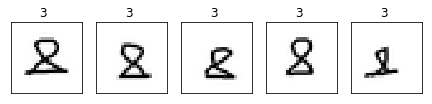

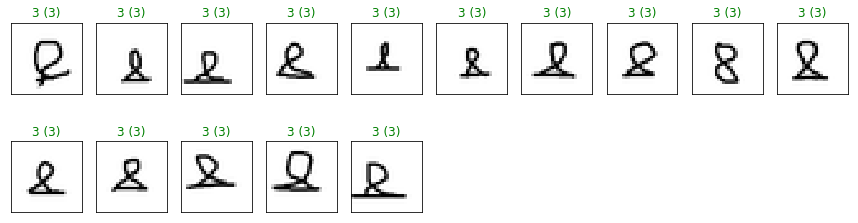

In [0]:
# get sample outputs
labels = y[choose_class*15:choose_class*15+15]
support_lbl = np.ones(len(support_imgs), dtype=np.int16) * choose_class
# get output i.e., predicted class
preds = pred[choose_class*15:choose_class*15+15]
# prep images for display
s_images = support_imgs.cpu().numpy()
q_images = query_imgs.cpu().numpy()


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(s_images[idx]), cmap='gray')
    ax.set_title("{} ".format(str(support_lbl[idx])))

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 4))
for idx in np.arange(15):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(q_images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))